In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## for correlation matrices
import seaborn as sns
%matplotlib inline
## for linear models
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ConfusionMatrix

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing

# from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report

%run ../pyfiles/data_cleaning.py
%run ../pyfiles/grid_search.py

In [176]:
from imblearn.over_sampling import SMOTE

In [177]:
# Set global random seed
np.random.seed(123)

### Import data and drop redundant data (rates)

In [179]:
# import data
orig = pd.read_csv('../../data/deepsolar_tract.csv', encoding = "utf-8")
# orig.drop('Unnamed: 0', axis = 1, inplace = True)

# fips is a unique identifier
# Set fips as index 

orig.set_index(keys = 'fips', inplace = True)

### Add more data on opportunity zones

In [180]:
df = drop_redundant_columns(orig)

In [181]:
# Create our target column 'has_tiles', and drop additional redundant columns

df = create_has_tiles_target_column(df)

In [182]:
# # Figure out which variables are highly correlated, remove the most correlated ones one by one

# corr = pd.DataFrame((df.corr() > 0.8).sum())
# corr.sort_values(by = 0, ascending = False)[0:5]

In [183]:
# # Add highly correlated variables to list 'to_drop'
# to_drop = ['poverty_family_count','education_population','population', 'household_count','housing_unit_occupied_count', 'electricity_price_overall']

In [184]:
# # Drop highly colinear variables
# df = df.drop(to_drop, axis = 1)

In [185]:
# VIF score

### Checking for missing values

In [186]:
nulls = pd.DataFrame(df.isna().sum())
nulls.columns = ["missing"]
nulls[nulls['missing']>0].head()

,missing
average_household_income,886
gini_index,847
land_area,24
per_capita_income,643
population_density,316


In [187]:
# drop all missing values
df = df.dropna(axis = 0)

In [188]:
# Check class imbalance
df.has_tiles.value_counts()

1    41601
0    12498
Name: has_tiles, dtype: int64

In [189]:
len(df.columns)

131

### Train test split

In [190]:
X = df.drop('has_tiles', axis = 1)
y = df['has_tiles']

In [191]:
df.shape

(54099, 131)

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

### SMOTE!

In [193]:
smt = SMOTE()
Xtrain, ytrain = smt.fit_sample(X_train, y_train)
print(ytrain.value_counts(),'\n\n', y_test.value_counts())

1    33281
0    33281
Name: has_tiles, dtype: int64 

 1    8320
0    2500
Name: has_tiles, dtype: int64


### Scale Data 

In [194]:
scaler = StandardScaler()
X_train = scaler.fit_transform(Xtrain)
X_test = scaler.transform(X_test)

In [195]:
X_train.shape

(66562, 130)

### Model

In [196]:
from sklearn.metrics import confusion_matrix

In [199]:
dt = find_hyperparameters(pipe_dt, params_dt, X_train, ytrain)

KeyboardInterrupt: 

In [69]:
dt.best_params_
best_dt = dt.best_estimator_
# Decision Tree: {'dt__max_depth': 2, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}

In [70]:
best_dt.fit(X_train, ytrain)
best_dt.score(X_test, y_test)
# Decision Tree: 1.0

1.0

C:\Users\allis\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


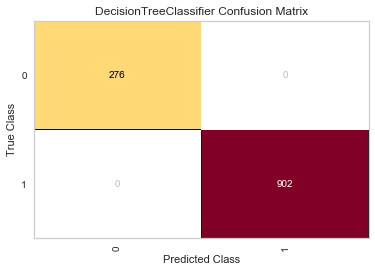

In [75]:
cm = ConfusionMatrix(best_dt)
cm.score(X_test, y_test)
cm.poof()

### Steps for Modeling


Gridsearch:
Try -  All our variables in logisitic regression
 - params: C and penalty
 
Gridsearch:
Try - All variables in decision trees
 - params: max_depth (5, 8, 15, 25, 30), min_samples_split (1, 2, 5, 10, 15, 100), min_samples_leaf (1, 2, 5, 10)
 - max_depth : how deep the tree is
 - min_samples_split: minimum number of samples required to split an internal node
 - min_samples_leaf: he minimum number of samples that we want a leaf node to contain


Try - Random forest
 - params: n_estimators (120, 300, 500, 800), max_depth(5, 8, 15, 25, 30), min_samples_split(1, 2, 5, 10, 15, 100), min_samples_leaf(1, 2, 5, 10), max_features (log2, sqrt, None)

Try - SVM
 - params: C(.001, .01, 0.1, 1, 10, 100, 1000), gamma ('auto','scale'), class_weight ('balanced', None)

Try - KNN
 - params: n_neighbors (2, 4, 8, 16), p (2,3)

Then try all again with PCA


In [12]:
from sklearn.pipeline import Pipeline

In [80]:
# Decision Tree Classifier
parameters = {'max_depth':[2, 3, 4, 5, 8], 'min_samples_split':[2, 5, 10, 15, 100], 'min_samples_leaf':[1, 2, 5, 10]}
dt = GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5)
dt.fit(X_train, ytrain)
dt.best_params_

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 4, 5, 8],
                       

In [81]:
dt.best_params_

{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}